# Extracción de características

## Electroencefalograma

El objetivo de está práctica es procesar la señal EEG con el fin de detectar el P300.

El P300 es una deflexión positiva en la actividad eléctrica cerebral que está relacionada a la percepción de un estímulo infrecuente, pero esperado. En forma resumida, para provocar P300 los sujetos están atentos a una pantalla que presenta secuencias aleatorias de estímulos; únicamente algunos de los estímulos son de interés para los sujetos, es por ello que se les llama estímulos target. Por el contrario, los estímulos que no son de interés (no-target) sirven unicamente para aumentar la infrecuencia de los estímulos target y así potenciar el P300. Mientras se realiza la estimulación, se está registrando la actividad eléctrica cerebral de los sujetos a través de Electroencefalograma (EEG).

Para obtener el potencial evocado, la técnica más utilizada es la promediación, que consiste en realizar varias estimulaciones sucesivas y promediar las respuestas registradas (promedio de ensamble de épocas).

En la Figura 1 se puede representar de forma esquemática esta técnica.

El resultado de promediar el registro de N respuestas astpa dado por la siguiente ecuación:
\begin{equation}
    V(t) = \frac{\sum_{i=1}^{N}V_t(t)}{N} 
\end{equation}

## Actividades
1. Descargar el archivo 'P300.zip'
2. Diseñar una función que permita segmentar el EEG en épocas con una duración de 600 ms
3. Diseñar una función que obtenga el promedio ensamble de las épocas
4. Diseñar e implementar diferente sistemas de filtrado con y sin compensación de fase, utilizar una banda de paso entre 1 y 15 Hz
    * Filtro FIR
    * Chebyshev tipo 1 y 2
    * Butherworth
5. Calcular el promedio coherente de la señal original y filtrada
6. Comparar las latencias del P300 entre los promedios coherentes

### Información adicional:
* Un canal de EEG con frecuencia de muestreo de 512 Hz.
* Un vector de unos y ceros, uno índica estímulo target y cero un estímulo no-target.
* un vector con índices del número de muestra donde inicia cada época.

#### Importar las librerías

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg
import pandas as pd
import os
import zipfile

#### Definir funciones propias

##### Función para calcular FFT en dB de una señal

In [4]:
def fou(senal,sr):
    """senal: señal a la que desea obtener la transformada de Fourier
    sr: Frecuencia de muestreo de la señal"""
    f  = np.fft.fft(senal)
    h  = 20*np.log10(np.abs(f))[:int(f.shape[0]//2)]
    w  = np.linspace(0,sr//2,f.shape[0]//2 )

    return h, w

##### Función para caracterizar filtros

In [5]:
def freqz_plot(b,a,sr):
    """ba: coeficientes del diseño del filtro
    sr: Frecuencia de muestreo"""
    w, h = sg.freqz(b,a)
    h[h==0] = 1E-5

    H = 20*np.log10( np.abs(h))
    W = np.angle(h)
    W = np.unwrap(W)
    W = np.degrees(W)
    w = np.linspace(0,sr//2,H.shape[0] )

    return w, W, H

#### Función para segmentar señal por épocas y calcular promedio de ensamble

In [6]:
def meancoher(EEG, Fe, Fs, ind, tars):
    L   = int(Fe*Fs)   #Número de muestras en cada epoca
    m   = ind.shape[0] #Longitud vector indices: número de epocas
    epo = []           #Matriz vacia de epocas

  #Llenado de la matriz de epocas
    for j in range(0,m):
        epo.append(  EEG[int(ind[j]):int(ind[j])+L]  )

    epo = np.array(epo)

    E_T  = epo[tars==1].mean(axis=0) #Promedio coherente de epocas target
    E_NT = epo[tars==0].mean(axis=0) #Promedio coherente de epocas no target
    t_E  = np.linspace(0,Fe,L)     #Eje de tiempo para promedio de epocas

    return E_T, E_NT, t_E


#### Configuración de Path

In [14]:
# Path donde se encuentran las señales
datapath = os.path.abspath('../signals/')
print(datapath)


# Path para guardar los archivos del zip
signal_savepath = os.path.abspath('../signals/')

## Path donde se guardarán las imágenes
# savepath = os.path.abspath('')
# print(savepath)

/home/gerardo/Documentos/Repositorios/Procesamiento_biose-ales/signals


#### Importación y análisis de la señal

In [16]:
# Ruta del archivo ZIP
zip = os.path.join(datapath, 'P300.zip')

with zipfile.ZipFile(zip, "r") as zip_ref:
    # Lista los nombres de los archivos dentro del archivo ZIP
    lista_archivos = zip_ref.namelist()
    # Extraer todos los archivos en el directorio de destino
    zip_ref.extractall(signal_savepath)

In [17]:
print(lista_archivos)

['P300_CZ.csv', 'P300_params.csv']


In [18]:
# Cargar los datos de la señal
P300_CZ = os.path.join(signal_savepath, lista_archivos[0])
P300 = pd.read_csv(P300_CZ)
P300 = P300.values
P300 = P300[:,0]

P300_params = os.path.join(signal_savepath, lista_archivos[1])
params = pd.read_csv(P300_params,sep = ' ')
params = params.values
tars = params[:,0]
ind  = params[:,1]
Fs   = 512.
t    = np.linspace(0,P300.shape[0]/float(Fs),P300.shape[0])
t_ep = 0.60

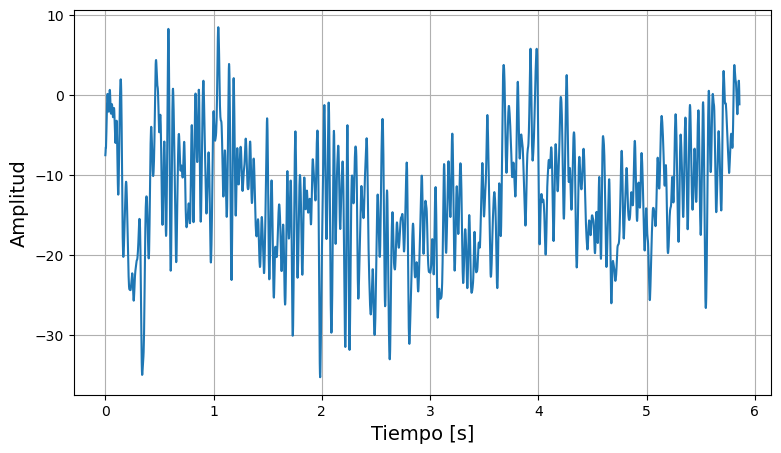

In [19]:
# Gráfica de la señal EEG 
plt.figure(figsize=(9,5))
plt.plot(t[:3000], P300[:3000])
plt.xlabel('Tiempo [s]', fontsize=14)
plt.ylabel('Amplitud', fontsize=14)
plt.grid(True)
# plt.savefig(os.path.join(savepath, 'EEG_CZ.png'))

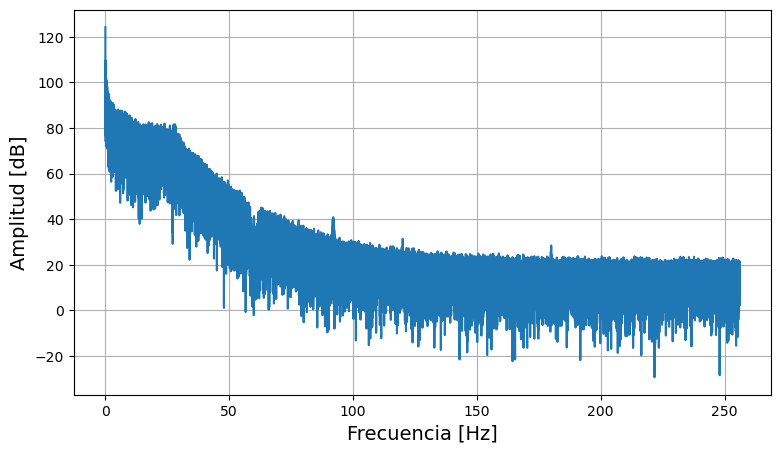

In [20]:
# FFT
h, w = fou(P300, Fs)

plt.figure(figsize=(9,5))
plt.plot(w,h)
plt.xlabel('Frecuencia [Hz]', fontsize=14)
plt.ylabel('Amplitud [dB]', fontsize=14)
plt.grid(True)
# plt.savefig(os.path.savepath, 'FFT_CZ.png'))

####  Filtro FIR tipo 1

In [21]:
# Esquema de filtrado de FIR tipo 1 y ventana hamming
n   = 151
fc  = 2*np.array([1,16])/Fs
FIR = sg.firwin(n, fc, pass_zero=False)

# Respuesta en frecuencia del filtro
wFIR, WFIR, HFIR = freqz_plot(FIR, [1.], Fs)

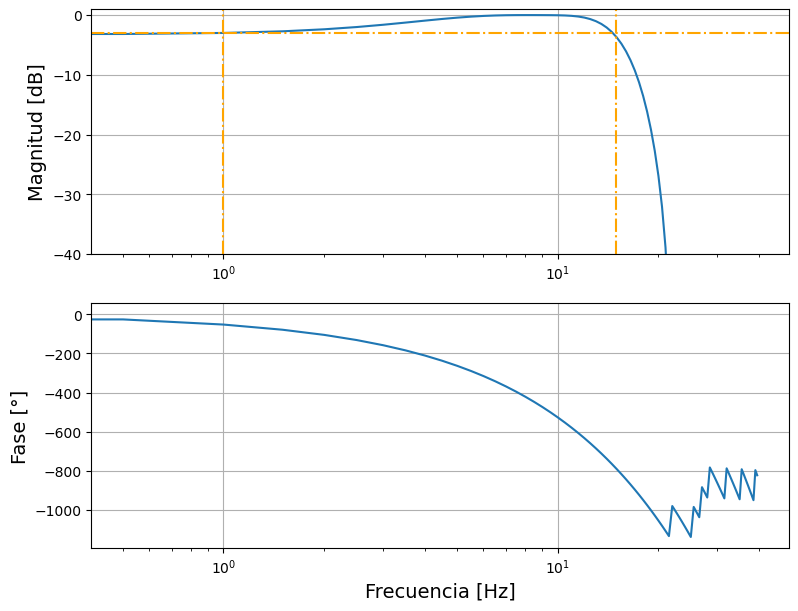

In [22]:
# Respuesta en frecuencia de filtro FIR tipo 1
plt.figure(figsize=(9,7))
plt.subplot(2,1,1)
plt.semilogx(wFIR[:80], HFIR[:80])
plt.axhline(y=-3, ls='-.', color='orange')
plt.axvline(x=1, ls='-.', color='orange')
plt.axvline(x=15, ls='-.', color='orange')
plt.ylim(-40, 1)
plt.ylabel('Magnitud [dB]', fontsize=14)
plt.grid(True)

plt.subplot(2,1,2)
plt.semilogx(wFIR[:80], WFIR[:80])
plt.ylabel('Fase [°]', fontsize=14)
plt.xlabel('Frecuencia [Hz]', fontsize=14)
plt.grid(True)
# plt.savefig(savepath, 'RF_FIR1.png'))

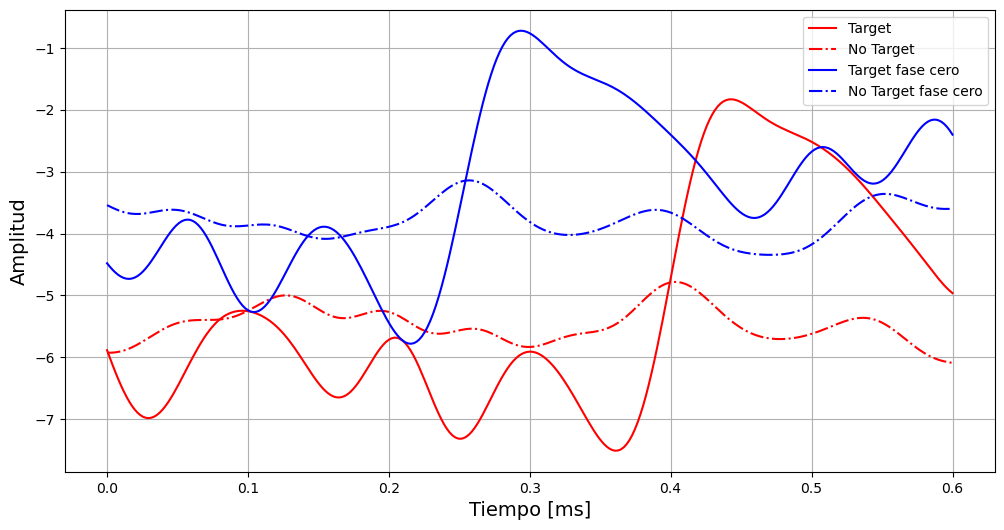

In [23]:
# Filtrado de la señal FIR tipo 1
P300_1 = sg.lfilter(FIR, [1.], P300)
P300_2 = sg.filtfilt(FIR, [1.], P300)

FIR_T1, FIR_NT1, t1 = meancoher(P300_1, t_ep, Fs, ind, tars)
FIR_T2, FIR_NT2, t2 = meancoher(P300_2, t_ep, Fs, ind, tars)

plt.figure(figsize=(12,6))
plt.plot(t1, FIR_T1, color='red', label='Target')
plt.plot(t1, FIR_NT1, '-.', color='red', label='No Target')
plt.plot(t2, FIR_T2, color='blue', label='Target fase cero')
plt.plot(t2, FIR_NT2, '-.', color='blue', label='No Target fase cero')
plt.xlabel('Tiempo [ms]', fontsize=14)
plt.ylabel('Amplitud', fontsize=14)
plt.legend()
plt.grid(True)
# plt.savefig(savepath, 'P300_FIR.png'))

#### Filtro Chebyshev tipo 1

In [24]:
# Esquema de filtrado Chebyshev tipo 1 
n  = 4
fc = 2*np.array([1,15])/Fs
bCHE1, aCHE1 = sg.cheby1(n, 3, fc, btype='bandpass')

# Respuesta en frecuecnia del filtro 
wCHE1, WCHE1, HCHE1 = freqz_plot(bCHE1, aCHE1, Fs)

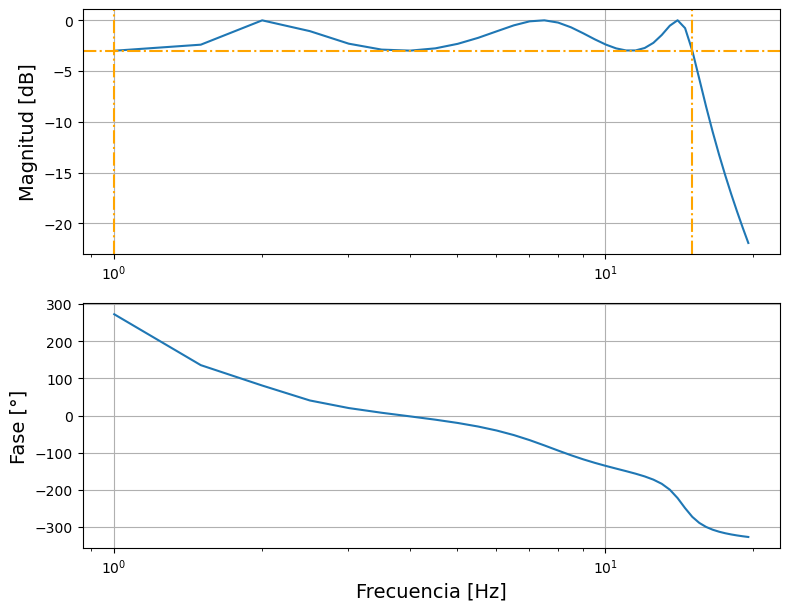

In [25]:
# Respuesta en frecuencia del filtro Chebyshev tipo 1
plt.figure(figsize=(9,7))
plt.subplot(2,1,1)
plt.semilogx(wCHE1[2:40], HCHE1[2:40])
plt.axhline(y=-3, ls='-.', color='orange')
plt.axvline(x=1, ls='-.', color='orange')
plt.axvline(x=15, ls='-.', color='orange')
plt.ylabel('Magnitud [dB]', fontsize=14)
plt.grid(True)

plt.subplot(2,1,2)
plt.semilogx(wCHE1[2:40], WCHE1[2:40])
plt.ylabel('Fase [°]', fontsize=14)
plt.xlabel('Frecuencia [Hz]', fontsize=14)
plt.grid(True)
# plt.savefig(os.path.join(savepath, 'RF_Che1.png'))

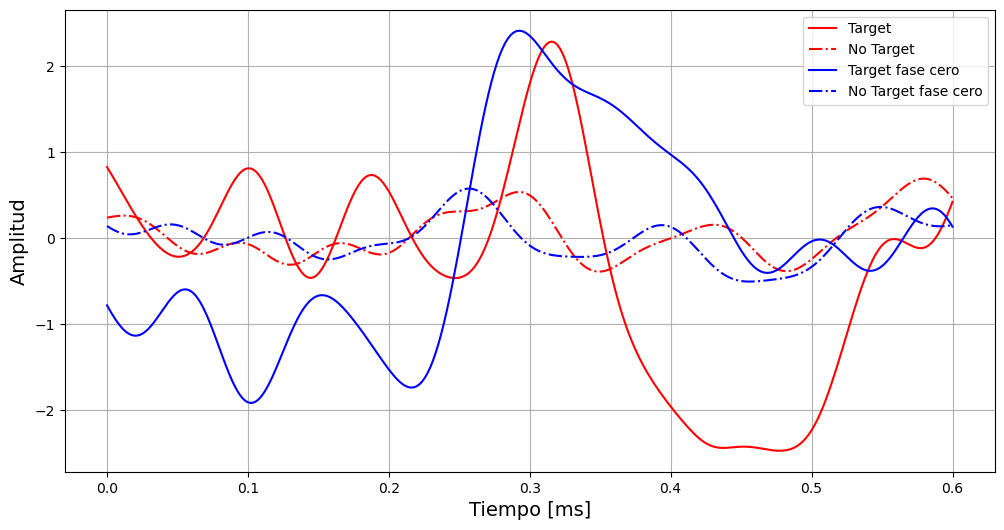

In [26]:
# Filtrado de la señal
P300_1 = sg.lfilter(bCHE1, aCHE1, P300)
P300_2 = sg.filtfilt(bCHE1, aCHE1, P300)

CHE1_T1, CHE1_NT1, t1 = meancoher(P300_1, t_ep, Fs, ind, tars)
CHE1_T2, CHE1_NT2, t2 = meancoher(P300_2, t_ep, Fs, ind, tars)

plt.figure(figsize=(12,6))
plt.plot(t1, CHE1_T1, color='red', label='Target')
plt.plot(t1, CHE1_NT1, '-.', color='red', label='No Target')
plt.plot(t2, CHE1_T2, color='blue', label='Target fase cero')
plt.plot(t2, CHE1_NT2, '-.', color='blue', label='No Target fase cero')
plt.xlabel('Tiempo [ms]', fontsize=14)
plt.ylabel('Amplitud', fontsize=14)
plt.legend()
plt.grid(True)
# plt.savefig(os.path.join(savepath, 'P300_Che1.png'))

#### Filtro Chebyshev tipo 2

In [27]:
# Esquema de filtrado Chebyshev tipo 2
n  = 4
fc = 2*np.array([1,15])/Fs
bCHE2, aCHE2 = sg.cheby2(n, 3, fc, btype='bandpass')

# Respuesta en frecuecnia del filtro 
wCHE2, WCHE2, HCHE2 = freqz_plot(bCHE2, aCHE2, Fs)

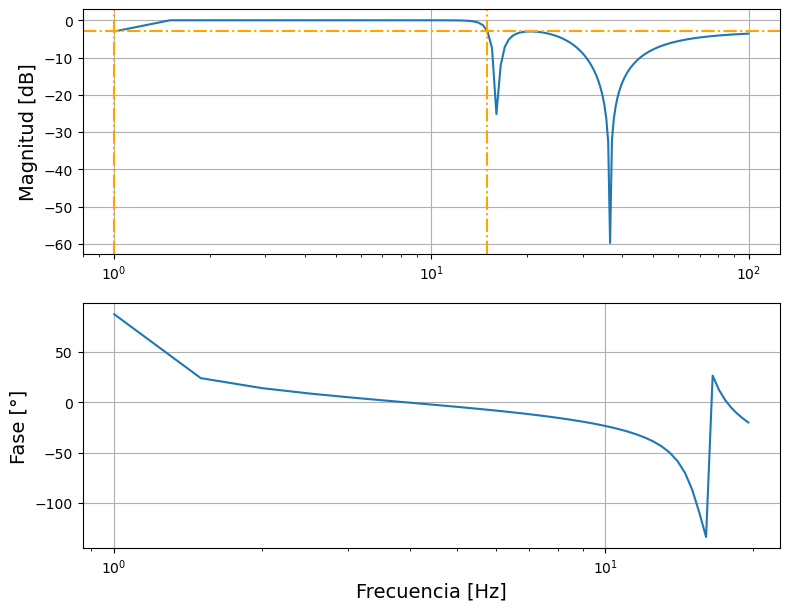

In [28]:
# Respuesta en frecuecnia del filtro Chebyshev tipo 2
plt.figure(figsize=(9,7))
plt.subplot(2,1,1)
plt.semilogx(wCHE2[2:200], HCHE2[2:200])
plt.axhline(y=-3, ls='-.', color='orange')
plt.axvline(x=1, ls='-.', color='orange')
plt.axvline(x=15, ls='-.', color='orange')
plt.ylabel('Magnitud [dB]', fontsize=14)
plt.grid(True)

plt.subplot(2,1,2)
plt.semilogx(wCHE2[2:40], WCHE2[2:40])
plt.ylabel('Fase [°]', fontsize=14)
plt.xlabel('Frecuencia [Hz]', fontsize=14)
plt.grid(True)
# plt.savefig(os.path.join(savepath, 'RF_Che2.png'))

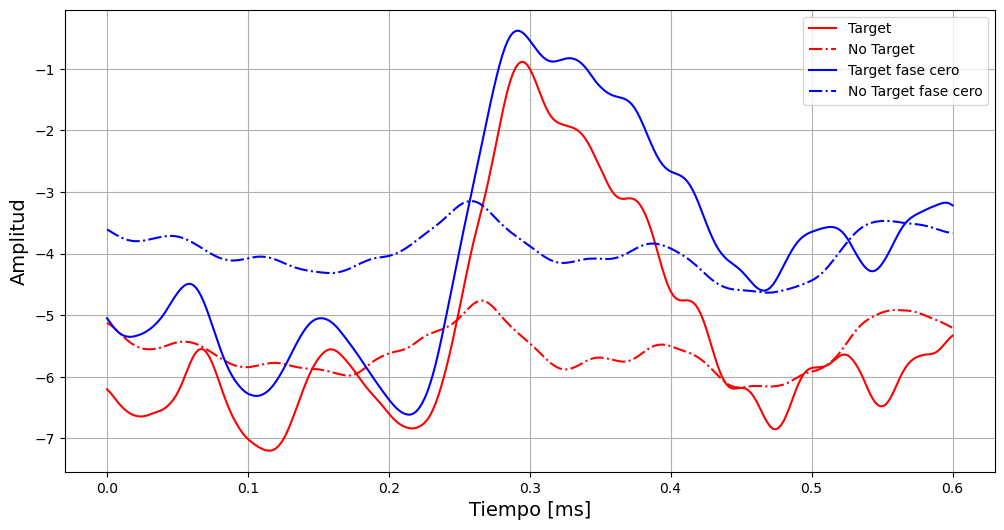

In [29]:
# Filtrado de la señal
P300_1 = sg.lfilter(bCHE2, aCHE2, P300)
P300_2 = sg.filtfilt(bCHE2, aCHE2, P300)

CHE2_T1, CHE2_NT1, t1 = meancoher(P300_1, t_ep, Fs, ind, tars)
CHE2_T2, CHE2_NT2, t2 = meancoher(P300_2, t_ep, Fs, ind, tars)

plt.figure(figsize=(12,6))
plt.plot(t1, CHE2_T1, color='red', label='Target')
plt.plot(t1, CHE2_NT1, '-.', color='red', label='No Target')
plt.plot(t2, CHE2_T2, color='blue', label='Target fase cero')
plt.plot(t2, CHE2_NT2, '-.', color='blue', label='No Target fase cero')
plt.xlabel('Tiempo [ms]', fontsize=14)
plt.ylabel('Amplitud', fontsize=14)
plt.legend()
plt.grid(True)
# plt.savefig(os.path.join(savepath, 'P300_Che2.png'))

#### Filtro Butherworth

In [30]:
# Esquema de filtrado Chebyshev tipo 2
n  = 2
fc = 2*np.array([1,15])/Fs
bBU, aBU = sg.butter(n, fc, btype='bandpass')

# Respiuesta en frecuencia del filtro 
wBU, WBU, HBU = freqz_plot(bBU, aBU, Fs)

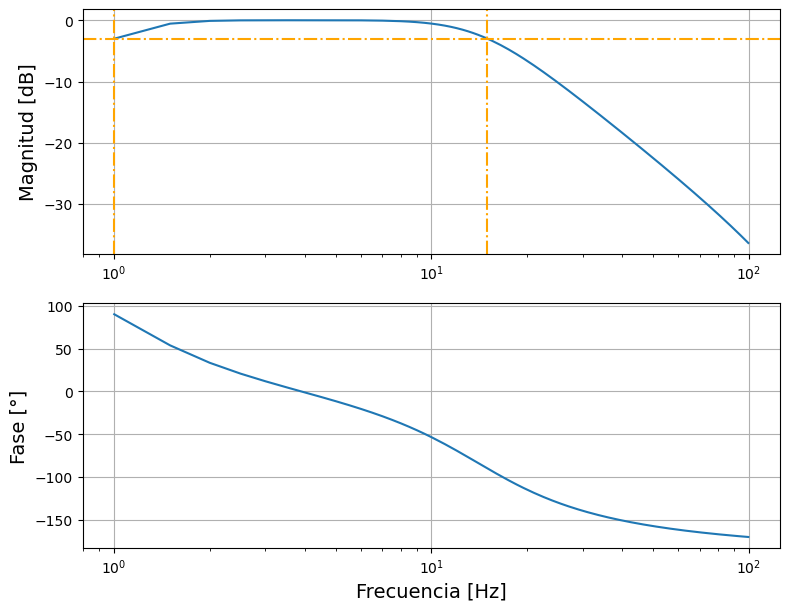

In [31]:
# Respuesta en frecuencia del filtro Butherworth 
plt.figure(figsize=(9,7))
plt.subplot(2,1,1)
plt.semilogx(wBU[2:200], HBU[2:200])
plt.axhline(y=-3, ls='-.', color='orange')
plt.axvline(x=1, ls='-.', color='orange')
plt.axvline(x=15, ls='-.', color='orange')
plt.ylabel('Magnitud [dB]', fontsize=14)
plt.grid(True)

plt.subplot(2,1,2)
plt.semilogx(wBU[2:200], WBU[2:200])
plt.ylabel('Fase [°]', fontsize=14)
plt.xlabel('Frecuencia [Hz]', fontsize=14)
plt.grid(True)
# plt.savefig(os.path.join(savepath, 'RF_Bu.png'))

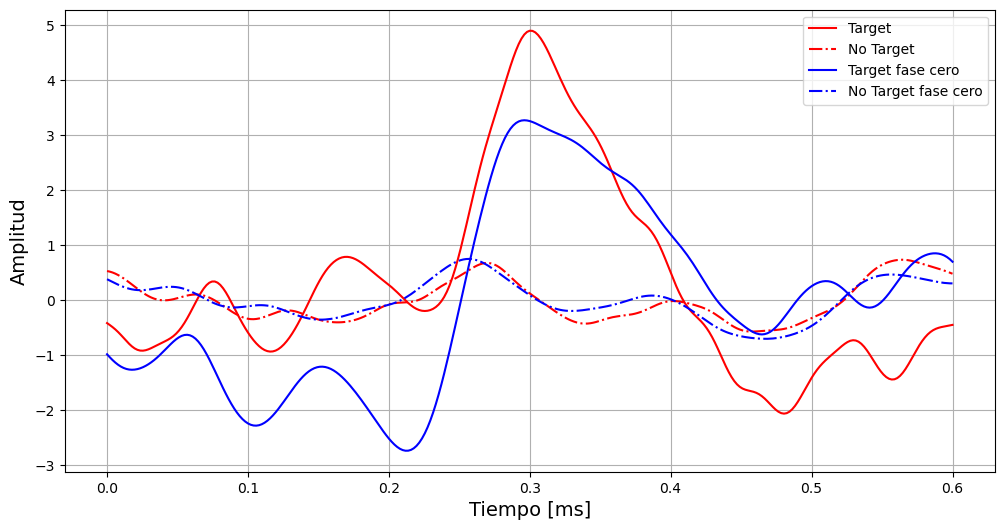

In [32]:
# Filtrado de la señal
P300_1 = sg.lfilter(bBU, aBU, P300)
P300_2 = sg.filtfilt(bBU, aBU, P300)

BU_T1, BU_NT1, t1 = meancoher(P300_1, t_ep, Fs, ind, tars)
BU_T2, BU_NT2, t2 = meancoher(P300_2, t_ep, Fs, ind, tars)

plt.figure(figsize=(12,6))
plt.plot(t1, BU_T1, color='red', label='Target')
plt.plot(t1, BU_NT1, '-.', color='red', label='No Target')
plt.plot(t2, BU_T2, color='blue', label='Target fase cero')
plt.plot(t2, BU_NT2, '-.', color='blue', label='No Target fase cero')
plt.xlabel('Tiempo [ms]', fontsize=14)
plt.ylabel('Amplitud', fontsize=14)
plt.legend()
plt.grid(True)
# plt.savefig(os.path.join(savepath, 'P300_Bu.png'))